In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

import torch
from torch import Tensor
from torch import Tensor as T
from torch.utils.data import DataLoader, Subset
from torch import nn
import torch.optim
from torch.optim import SGD
import torch.nn.functional as F

import keras
L = keras.layers

import sys
sys.path.append('../code')

import toy_data as toy
from vae import VAE, loss_function, cVAE, fit
import vae as v

from sklearn import gaussian_process

from tqdm_utils import TqdmProgressCallback
from sklearn.decomposition import PCA
from tqdm import tqdm_notebook as tqdm

from contextlib import ExitStack
from functools import partial

def plot_reconstruction(recon, orig):
    fig, ax = plt.subplots(ncols=2)
    ax[0].imshow(recon)
    ax[1].imshow(orig)
    ax[0].set_title('Reconstruction of an validation image.')
    ax[1].set_title('Original')
    plt.show()
    
def plot_sample_grid(sample):
    assert len(sample) >= 9
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True)
    fig.set_size_inches((10, 10))
    for i in range(9):
        img = sample[i]
        ind = to_ind[i]
        ax[ind[0], ind[1]].imshow(img.reshape(*img_shape))
    plt.tight_layout()
    plt.show()
    
def draw_samples(model):
    with torch.no_grad():
        sample = torch.randn(9, bottleneck).to(device)
        sample = model.decode(sample).cpu().numpy()
    return sample

# Some parameters:
N = 3600000  # number of observations
batch_size = 512
d = 64  # image edge length
D = d**2
img_shape = (d, d)
print(f"{N} points with {D} dimensions.")

# useful for plotting on a 3x3 grid:
to_ind = np.array(list(product(range(3), range(3))))

# setting up torch
device = 'cuda' if torch.cuda.is_available() else "cpu"
print(f'Pytorch: Train with {device}')
device = torch.device(device)

3600000 points with 4096 dimensions.
Pytorch: Train with cuda


# Toy data: Images of hierarchical structures without time dependency

Generate (d, d)-pixel images from 7 parameters: 
- 3 angles for each image, 
- 3 bone lengths and keypoint marker width shared for whole dataset. 

Origin of the 3-bone hierarchy is the central pixel.
End of bones are marked by squared exponentials.

In [23]:
# parameters:
eps = np.random.rand(3)
bone_lengths = d//6 * (eps/2+1-1/3)
print("Bone lengths:", bone_lengths)
key_marker_width = 1.5 * d/32
labels = 1/2*np.pi*(np.random.rand(N, 3)-0.5)
labels[:, 0] = labels[:, 0] * 4

# generate training data
h = toy.HierarchyImages(angles=labels, bone_lengths=bone_lengths,
                        key_marker_width=key_marker_width,
                        img_shape=img_shape)

# data loader for easy batching
data_loader = DataLoader(h, batch_size=batch_size, shuffle=True, num_workers=4,
                         drop_last=True)

# generate validation data
labels_val = 1/2*np.pi*(np.random.rand(N//10, 3)-0.5)
labels_val[:, 0] = labels_val[:, 0] * 4

h_val = toy.HierarchyImages(angles=labels_val, bone_lengths=bone_lengths,
                            key_marker_width=key_marker_width,
                            img_shape=img_shape)

val_loader = DataLoader(h_val, batch_size=batch_size, shuffle=False, num_workers=4,
                        drop_last=True)

# dataloader dictionary with reduced validation set size
dataloader = {'train': data_loader,
              'val': DataLoader(torch.utils.data.Subset(h_val, np.random.choice(range(len(h_val)), size=1024)),
                               drop_last=True, batch_size=batch_size)}

# dataloader with size comparable of PCA's datasize limit
subsets = {k: Subset(h, np.random.choice(range(len(v)), size=5000)) for k, v in zip(['train', 'val'], [h, h_val])}
reduced_dataloader = {k: DataLoader(subsets[k], batch_size=batch_size, drop_last=True) for k in subsets}

# generate, encode, and decode new image for validation
idx = np.random.randint(0, len(h_val))
test_img = h_val[idx]['image']
test_angles = h_val[idx]['angles']

Bone lengths: [10.53710584  9.9678381  10.76753448]


In [ ]:
h.plot_image(np.random.randint(0, len(labels)))

## PCA

In [ ]:
# Use subset of data because of memory restriction
idxs = np.random.choice(range(len(h)), replace=False, size=D)
imgs = np.array([h[i]['image'] for i in idxs])
X = np.reshape(imgs, (len(idxs), d**2))
pca = PCA().fit(X)
# n_comp = pca.n_components

vexpl = np.cumsum(pca.explained_variance_ratio_)
plt.plot(vexpl)
thresh = 0.95
n_comp = np.where(vexpl > thresh)[0][0]
plt.vlines(n_comp, 0, 1, linestyles='dotted')
plt.hlines(thresh, 0, 800, linestyles='dotted')
plt.title(f'{n_comp} components explain {thresh} of the variance')
plt.show()

In [ ]:
# Plot first 9 components
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True)
ax[0, 1].set_title('First 9 principle components are fourier decomposition on a circle.')
for i in range(9):
    x, y = to_ind[i]
    comp = pca.components_[i].reshape(img_shape)
    ax[x, y].imshow(comp)
# plt.tight_layout()
plt.show()

In [ ]:
w = pca.transform(test_img.ravel()[None])[:, :n_comp]

recon_img = np.dot(w, pca.components_[:n_comp])[0].reshape(*img_shape)
recon_img = recon_img + pca.mean_.reshape(*img_shape)
plot_reconstruction(recon_img, test_img)

In [ ]:
# dataloader = {'train': data_loader,
#               'val': val_loader}

loss = {}
loss_pp = {}
for phase in reduced_dataloader.keys():
    loss[phase] = []
    for data in tqdm(reduced_dataloader[phase]):
        original = data['image'].view(-1, D).cpu().detach().numpy()
        w = pca.transform(original)[:, :n_comp]
        recon_img = np.dot(w, pca.components_[:n_comp])
        loss[phase] += [(recon_img - original)**2]
    loss_pp[phase] = np.mean(np.array(loss[phase]))
    
for k in reduced_dataloader.keys():
    print(f'PCA {k} loss: {loss_pp[k]}')

In [ ]:
# generate image from noise
W = pca.transform(X)[:, :n_comp]

# Using uniform noise because it matches the
# statistics of w better than gauss

min_w = W.min(axis=0)
span = W.max(axis=0) - min_w

n_examples = 6
eps = np.random.rand(n_examples, n_comp)
w_rand = span[None] * eps + min_w[None]

generated = np.dot(w_rand, pca.components_[:n_comp])

fig, ax = plt.subplots(ncols=n_examples, sharey=True)
fig.set_size_inches(n_examples*3, 3)
ax[n_examples//2].set_title('Using weights sampled from \nuniform distribution to generate image.')
for i in range(n_examples): 
    ax[i].imshow(generated[i].reshape(*img_shape))
plt.show()

## PCA by autoencoder

In [ ]:
def build_pca_autoencoder(img_shape, code_size):
    """
    Here we define a simple linear autoencoder.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector
    hidden = L.Dense(code_size)
    encoder.add(hidden)           #actual encoder

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    
    return encoder, decoder

In [ ]:
encoder, decoder = build_pca_autoencoder(img_shape, n_comp)
inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

autoencoder.fit(x=imgs, y=imgs, epochs=7,
#                 validation_data=[X_test, X_test],
                callbacks=[TqdmProgressCallback()],
                verbose=False)

In [ ]:
W, bias = encoder.get_weights()

fig, ax = plt.subplots(3, 3, sharex=True, sharey=True)
ax[0, 1].set_title('9 autoencoder components.')
for i in range(9):
    idx = np.random.randint(0, 100)
    x, y = to_ind[i]
    i = np.random.randint(0, W.shape[1])
    ax[x, y].imshow(np.reshape(W[:, idx] + bias[idx], img_shape))
plt.show()

```python
    s = keras.backend.get_session()
    s.run(hidden, {input_1: test_img})
    w = encoder(L.Input(test_img))
    recon_img = reconstruction(w)
    recon_img
```

-> I don't know how to access the hidden layer with keras. 
Therefore I switch to pytorch.

# Linear Autoencoder: Pytorch

In [ ]:
class LinearAutoencoder(nn.Module):
    def __init__(self, code_size=10):
        nn.Module.__init__(self)
        self.encoder = nn.Linear(D, code_size)
        self.decoder = nn.Linear(code_size, D)
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, h):
        return self.decoder(h)
    
    def forward(self, x):
        w = self.encode(x.view(-1, D))
        return self.decode(w)

In [ ]:
la = LinearAutoencoder(code_size=n_comp)
la.to(device)

optimizer = torch.optim.Adam(la.parameters(), lr=1e-3)

train_losses = {}
for epoch in range(8):
    for phase in ['train', 'val']:
        train_losses[phase] = []
        with ExitStack() as stack:
            pbar = stack.enter_context(tqdm(dataloader[phase], leave=True))
            if phase == 'val':
                stack.enter_context(torch.no_grad())
                
            for batch in pbar:
                data = batch['image'].float().to(device)
                recon = la(data.view(-1, D))
                l = torch.mean((recon - data.view(-1, D))**2)
                if phase == 'train':
                    l.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                train_losses[phase].append(l.cpu().detach().numpy())
                pbar.set_description(f'({phase}) Epoch {epoch}: MSE = {l:.5f}')
        print(phase, np.mean(train_losses[phase]) if phase =='val' else train_losses[phase][-1])

# plt.plot(train_losses)
# plt.show()

In [ ]:
recon = la(Tensor(test_img).view(-1, D).to(device)).cpu().detach().numpy().reshape(img_shape)
plot_reconstruction(recon, test_img)

## Variational Autoencoder

In [24]:
bottleneck = 3
model = VAE(input_dim=D, bottleneck=bottleneck,
            hidden=1000).to(device)
# train_loss = model.fit(data_loader, epochs=1,
#                        verbose=True)

loss_func = partial(v.loss_function, beta=1, likelihood='mse')


train loss: 5.08E-07
val loss: 3.57E-03



train loss: 5.08E-07
val loss: 3.57E-03



train loss: 5.07E-07
val loss: 3.57E-03


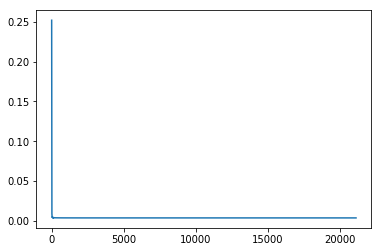

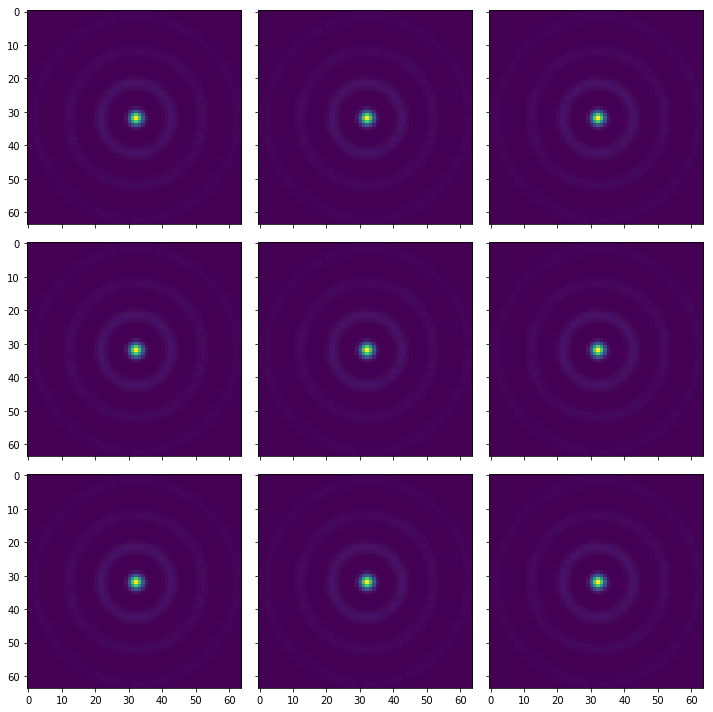


train loss: 5.35E+00
val loss: 3.76E+04



train loss: 5.12E+00
val loss: 3.59E+04



train loss: 5.02E+00
val loss: 3.52E+04


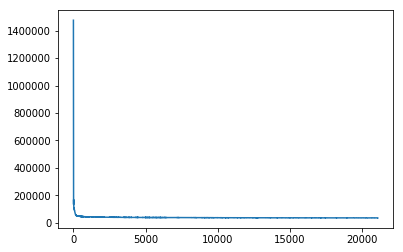

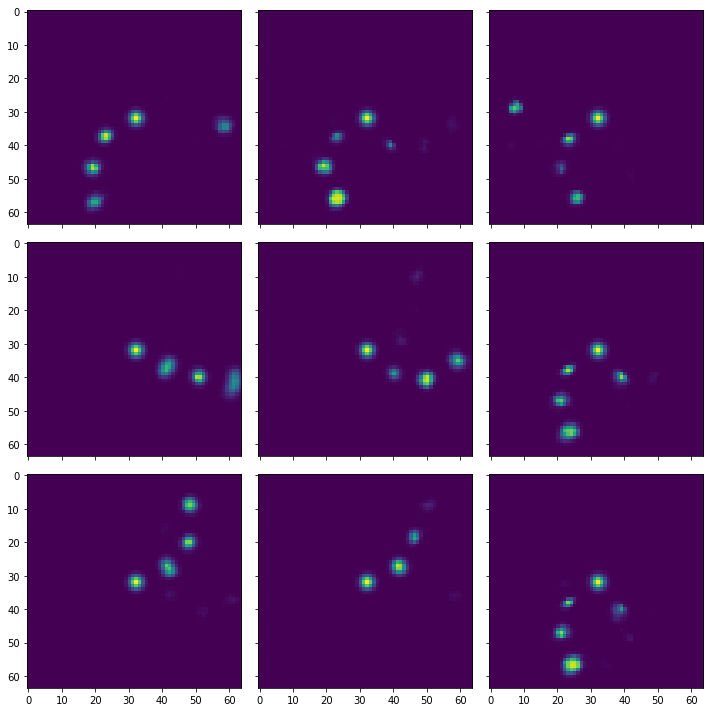

In [30]:
from IPython.core.debugger import set_trace
for likelihood in ['mse', 'bce']:
    model = VAE(input_dim=D, bottleneck=bottleneck,
                hidden=900).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_func = partial(v.loss_function, beta=1, likelihood=likelihood)
    train_loss = fit(model, dataloader, device=device, optimizer=optimizer,
                    epochs=3, loss_func=loss_func)

    skip = min(100, len(train_loss))
    plt.plot(train_loss[skip:])
    plt.show()
    plot_sample_grid(draw_samples(model))
    del model
    torch.cuda.empty_cache()

In [ ]:
recon, mu,logvar = model(Tensor(test_img).to(device))
print(mu)

recon = recon.cpu().detach().numpy().reshape(img_shape)
plot_reconstruction(recon, test_img)

In [ ]:
def get_img(ind):
    mu_np = mu.cpu().detach().numpy()
    fig, ax = plt.subplots()
    for x in np.linspace(-4, 4):
        mu_np[:, ind] = x
        mu_star = Tensor(mu_np).to(device)
        gen = model.decode(mu_star)
        gen = gen.cpu().detach().numpy().reshape(img_shape)
        yield (x, gen)

fig, ax = plt.subplots()
img = h[0]['image']

mimg = plt.imshow(img)
plt.close()

def init():
    mimg.set_data(img)
    return (mimg,)

def animate(img):
    x, img = img
    ax.set_title(f'{x:.3}')
    mimg.set_data(img)
    return (mimg,)

vids = []
for i in range(mu.shape[1]):
    g = get_img(i)
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=g, interval=120, 
                                   blit=True)
    vids += [anim.to_html5_video()]
    plt.close()

In [ ]:
HTML(vids[0])

In [ ]:
HTML(vids[1])

In [ ]:
HTML(vids[2])

## Conditional VAE

In [ ]:
weight_fn = 'cvae_weights.pt'
bottleneck = 8

cvae = cVAE(input_dim=D+3, bottleneck=bottleneck,
            cond_data_len=3,
            hidden=1500).to(device)
# cvae.to(device)

# torch.save(cvae.state_dict(), weight_fn)
cvae.load_state_dict(torch.load(weight_fn))

optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)
cvae.beta = 5
hist = fit(cvae, dataloader, epochs=42, optimizer=optimizer, device=device, weight_fn=weight_fn,
          conditional=True)
plt.plot(hist[100:])

In [ ]:
cvae.beta = 0.1
test_np = np.concatenate((h_val[0]['image'].ravel(), h_val[0]['angles']))[None]

optimizer=torch.optim.Adam(cvae.parameters(), lr=1e-2)

# for beta in [0.1, 0.5, 1, 2, 5, 10]:
cvae.to(device)
for beta in [2]:
#     cvae = cVAE(input_dim=D+3, bottleneck=bottleneck,
#                 cond_data_len=3,
#                 hidden=150).to(device)
    cvae.beta = beta
    hist = fit(cvae, dataloader, epochs=15, optimizer=optimizer,
              device=device, conditional=True)

    cvae.to('cpu')
    recon, mu, logvar = cvae(T(test_np))
    image = recon.cpu().detach().numpy()[0, :D].reshape(d, d)
    angles = recon.cpu().detach().numpy()[0, D:]
    plot_reconstruction(image, h_val[0]['image'])

    with torch.no_grad():
        sample = torch.randn(9, bottleneck+3).to('cpu')
        sample = cvae.decode(sample).cpu().numpy()

    plot_sample_grid(sample[:, :D])

In [ ]:
test_np = np.concatenate((h_val[0]['image'].ravel(), h_val[0]['angles']))[None]

cvae.to('cpu')
recon, mu, logvar = cvae(T(test_np))
image = recon.cpu().detach().numpy()[0, :D].reshape(d, d)
angles = recon.cpu().detach().numpy()[0, D:]
plot_reconstruction(image, h[0]['image'])

with torch.no_grad():
    sample = torch.randn(9, bottleneck+3).to('cpu')
    sample = cvae.decode(sample).cpu().numpy()

plot_sample_grid(sample[:, :D])

# Hierarchical image 

In [ ]:
# introduce time dependency
rbf = gaussian_process.kernels.RBF(length_scale=2)
rbf_slow = gaussian_process.kernels.RBF(length_scale=5)
GP = gaussian_process.GaussianProcessRegressor(kernel=rbf)
GP_slow = gaussian_process.GaussianProcessRegressor(kernel=rbf_slow)

N = 250
t = np.linspace(0, 120, N)
y = np.empty((N, len(bone_lengths)))
y[:, 0] = GP_slow.sample_y(t[:, None], random_state=None)[:, 0]*3
for i in range(1, len(bone_lengths)):
    y[:, i] = GP.sample_y(t[:, None], random_state=None)[:, 0]*0.7
labels = y
plt.plot(t, labels)

# angles can not escape [-np.pi, np.pi]
idx = abs(y) > np.pi
y[idx] = y[idx] - 2*np.sign(y[idx])*np.pi

In [ ]:
h = toy.HierarchyImages(labels, bone_lengths, key_marker_width=key_marker_width, img_shape=img_shape)
imgs = [h[i]['image'] for i in range(len(labels))]

In [ ]:
fig, ax = plt.subplots()
img = imgs[0]
mimg = plt.imshow(img)
plt.close()

def init():
    mimg.set_data(img)
    return (mimg,)

def animate(i):
    img = imgs[i]
    mimg.set_data(img)
    return (mimg,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(imgs), interval=60, 
                               blit=True)
# anim.save(f'Toyproblem_unambiguous_{d}x{d}.mp4')
html_video = anim.to_html5_video()

In [ ]:
HTML(html_video)